# Segmentation on the ISICs data set with the UNet

This improved UNet is developed by F. Isensee, P. Kickingereder, W. Wick, M. Bendszus, and K. H. Maier-Hein. As the standrad UNet, the improved UNet has two part, decoder and encoder.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import glob
from tensorflow.keras.layers import concatenate, Flatten
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model

## Load Image Dataset
The ISIC data set is a melanoma research data set. The data set used in this project is taken from 2018 data. Divided into input folder and groundtruth folder. Each dolder has 2594 image files.

In [2]:
# load image
isic_input = glob.glob("D:/2021S2/COMP3710/ass/report/ISIC2018_Task1-2_Training_Data/ISIC2018_Task1-2_Training_Input_x2/*.jpg")
isic_groundtruth = glob.glob("D:/2021S2/COMP3710/ass/report/ISIC2018_Task1-2_Training_Data/ISIC2018_Task1_Training_GroundTruth_x2/*.png")

In [3]:
len(isic_input)#check the length of dataset

2594

In [4]:
type(isic_input)

list

In [5]:
type(isic_input[0])

str

# Preprocess images dataset for next step

In [6]:
def preprocess_array(imagelist):
    data = []
    for fname in imagelist:
        image = np.asarray(PIL.Image.open(fname))
        image = tf.image.resize(image, (256,256))
        data.append(image)
    data = np.array(data, dtype=np.float32)
    return data

In [7]:
def preprocess_array_truth(imagelist):
    data = []
    for fname in imagelist:
        image = np.asarray(PIL.Image.open(fname))
        image = image[:,:,np.newaxis]
        image = tf.image.resize(image, (256,256), method = 'nearest')
        data.append(image)
    data = np.array(data, dtype=np.uint8)
    return data

In [8]:
#try small first
#testisic_input=isic_input[0:100]
#testisic_groundtruth=isic_groundtruth[0:100]    

In [9]:
#preprecess image to array to input modul
x = (preprocess_array(isic_input)) / 255.
 
y = np.round(preprocess_array_truth(isic_groundtruth) /255)
 

# Split dataset for train and test
the validation part will in fit model part

In [10]:
#split dataset,test set is 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
len(x)

2594

# Improved UNet 
Unet consists of two parts. The first part is feature extraction. The second part is the up-sampling part. In other words, encoder and decoder.

In [12]:
#unet module
from tensorflow.keras.layers import BatchNormalization , ReLU ,Dropout
from tensorflow.keras.layers import Input , Conv2D, Add
from tensorflow.keras.layers import UpSampling2D , concatenate, LeakyReLU
from tensorflow.keras.models import Model
def contextModel(input_layer,conv):
    # from easy, each context module is in fact a pre-activation residual block with two
    # 3x3x3 convolutional layers and a dropout layer (pdrop = 0.3) in between
    block = BatchNormalization()(input_layer)
    block = ReLU()(block)
    block = Conv2D(conv, (3, 3), padding='same')(block)
    # dropout layer (pdrop = 0.3) in between
    block = Dropout(0.3)(block)
    block = BatchNormalization()(block)
    block = ReLU()(block)
    block = Conv2D(conv, (3, 3), padding='same')(block)
    return block


def unetmodel():

    #encoder part
    input_layer = Input(shape=(256,256,3))
    #convolution
    conv1 = Conv2D(16,(3,3), padding='same')(input_layer)
    # context module
    contextModel1 = contextModel(conv1,16)
    #element wise sum
    ews1 = Add()([conv1,contextModel1])# ews = element wise sum
    #convolution stride2
    conv2 = Conv2D(32, (3, 3), strides=(2,2), padding='same')(ews1)
    # context module
    contextModel2 = contextModel(conv2, 32)
    # element wise sum
    ews2 = Add()([conv2, contextModel2])  # ews = element wise sum
    # convolution stride2
    conv3 = Conv2D(64, (3, 3), strides=(2,2), padding='same')(ews2)
    # context module
    contextModel3 = contextModel(conv3, 64)
    # element wise sum
    ews3 = Add()([conv3, contextModel3])  # ews = element wise sum
    # convolution stride2
    conv4 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(ews3)
    # context module
    contextModel4 = contextModel(conv4, 128)
    # element wise sum
    ews4 = Add()([conv4, contextModel4])  # ews = element wise sum
    # convolution stride2
    conv5 = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(ews4)
    # context module
    contextModel5 = contextModel(conv5, 256)
    # element wise sum
    ews5 = Add()([conv5, contextModel5])  # ews = element wise sum

    #decoder part
    # upsampling module
    up_layer6 = UpSampling2D((2, 2))(ews5)
    up_layer6 = Conv2D(128, (3, 3), activation= LeakyReLU(alpha= 0.01), padding='same')(up_layer6)
    # concatenate
    conc6 = concatenate([ews4, up_layer6])
    # localization module
    loca6 = Conv2D(128, (3, 3), activation= LeakyReLU(alpha= 0.01), padding='same')(conc6)
    loca6 = BatchNormalization()(loca6)
    loca6 = Conv2D(128, (1, 1), activation= LeakyReLU(alpha= 0.01),padding='same')(loca6)
    loca6 = BatchNormalization()(loca6)
    # upsampling module
    up_layer7 = UpSampling2D((2, 2))(loca6)
    up_layer7 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(up_layer7)
    # concatenate
    conc7 = concatenate([ews3, up_layer7])
    # localization module
    loca7 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(conc7)
    loca7 = BatchNormalization()(loca7)
    loca7 = Conv2D(64, (1, 1), activation=LeakyReLU(alpha=0.01), padding='same')(loca7)
    loca7 = BatchNormalization()(loca7)
    #segmentation layer
    seg7 = Conv2D(1,(1,1))(loca7)
    seg7 = UpSampling2D((2,2))(seg7)
    # upsampling module
    up_layer8 = UpSampling2D((2, 2))(loca7)
    up_layer8 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(up_layer8)
    # concatenate
    conc8 = concatenate([ews2, up_layer8])
    # localization module
    loca8 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(conc8)
    loca8 = BatchNormalization()(loca8)
    loca8 = Conv2D(32, (1, 1), activation=LeakyReLU(alpha=0.01), padding='same')(loca8)
    loca8 = BatchNormalization()(loca8)
    # segmentation layer
    seg8 = Conv2D(1, (1, 1))(loca8)
    seg8 = Add()([seg7, seg8])
    seg8 = UpSampling2D((2, 2))(seg8)
    # upsampling module
    up_layer9 = UpSampling2D((2, 2))(loca8)
    up_layer9 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(up_layer9)
    # concatenate
    conc9 = concatenate([ews1, up_layer9])
    #convolution
    conv9 = Conv2D(32, (3,3), activation = LeakyReLU(alpha=0.01), padding='same')(conc9)
    #segmentation layer
    seg9 = Conv2D(1, (1, 1))(conv9)
    seg9 = Add()([seg9, seg8])

    output_layer = Conv2D(1, (1,1),activation='sigmoid')(seg9)


    unetmodel = Model(input_layer,output_layer)
    return unetmodel

# Dice Coefficient for evaluting the performance of improved unet

In [13]:
import tensorflow.keras.backend as K 
def dice_coefficient(y_true, y_pred, s=1.):
   
    y_true = tf.convert_to_tensor(y_true, dtype='float32')
    y_pred = tf.convert_to_tensor(y_pred, dtype='float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    #s for avoid result equal to 0
    return (2. * intersection + s) / (K.sum(y_true_f) + K.sum(y_pred_f) + s)

# Fit train dataset with improved UNet module

In [14]:
def fit(model,x,y, epoch_size, batch):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     metrics=['accuracy',dice_coefficient])

    model.fit(x, y, epochs=epoch_size, batch_size=batch, validation_split=0.2)#in train set, 20% is for validation

In [15]:
unetmodel = unetmodel()

In [17]:
#fit unet module
fit(unetmodel,x_train,y_train,10,33)#try epoch_size=100 again

Epoch 1/10
51/51 [==============================] - 1147s 20s/step - loss: 0.2871 - accuracy: 0.8931 - dice_coefficient: 0.6353 - val_loss: 0.2991 - val_accuracy: 0.8910 - val_dice_coefficient: 0.5139
Epoch 2/10
51/51 [==============================] - 1030s 20s/step - loss: 0.2142 - accuracy: 0.9161 - dice_coefficient: 0.7112 - val_loss: 0.2638 - val_accuracy: 0.8995 - val_dice_coefficient: 0.6217
Epoch 3/10
51/51 [==============================] - 1019s 20s/step - loss: 0.2018 - accuracy: 0.9226 - dice_coefficient: 0.7278 - val_loss: 0.3824 - val_accuracy: 0.8754 - val_dice_coefficient: 0.4705
Epoch 4/10
51/51 [==============================] - 1008s 20s/step - loss: 0.1865 - accuracy: 0.9270 - dice_coefficient: 0.7444 - val_loss: 0.2266 - val_accuracy: 0.9101 - val_dice_coefficient: 0.6858
Epoch 5/10
51/51 [==============================] - 1020s 20s/step - loss: 0.1759 - accuracy: 0.9319 - dice_coefficient: 0.7626 - val_loss: 0.2466 - val_accuracy: 0.9089 - val_dice_coefficient: 0.

 # Using Dice Coefficient to evaluting trained module with test dataset

In [18]:
pred = np.round(unetmodel.predict(x_test,batch_size=4))

In [19]:
# dice coefficient
dice = dice_coefficient(y_test, pred, s=1.)
print(dice)

tf.Tensor(0.82858425, shape=(), dtype=float32)


# plot some results
Plot original image, ground truth image and predict image. Comparing these three images to evalute the performance of improve unet module.

In [30]:
def plotResult(display_list):
    
    plt.figure(figsize=(20,20))
    title= ['Original Image', 'Ground True', 'Predicted Image']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap="gray")
        plt.axis('off')
    plt.show()

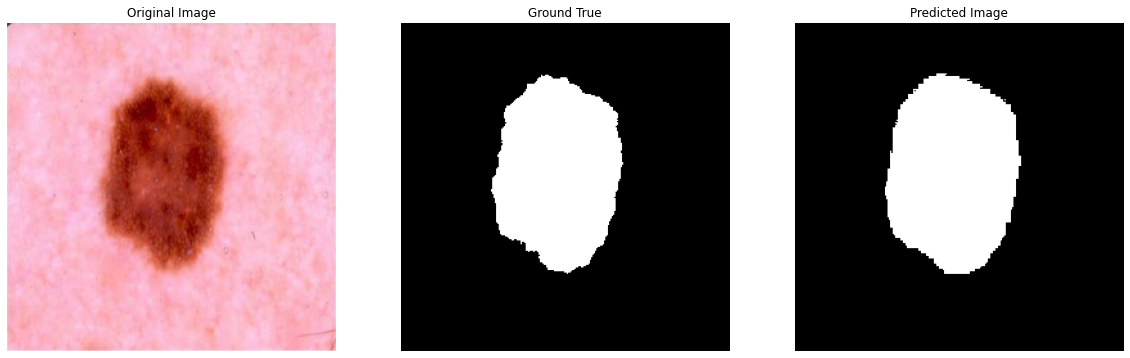

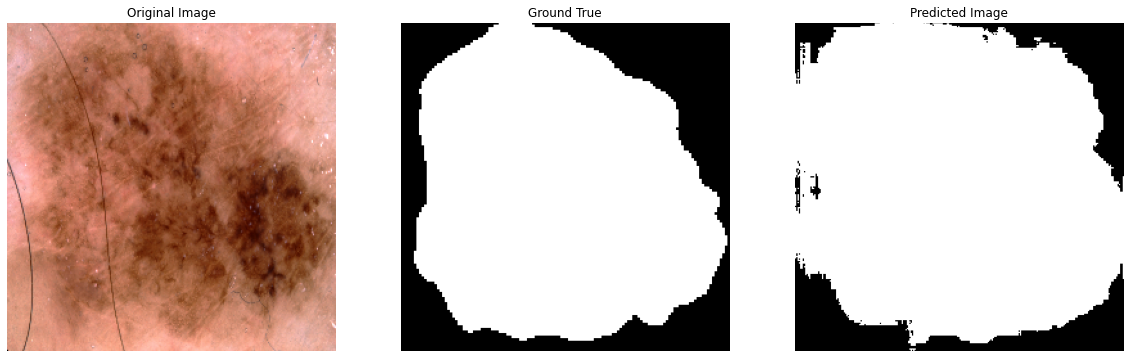

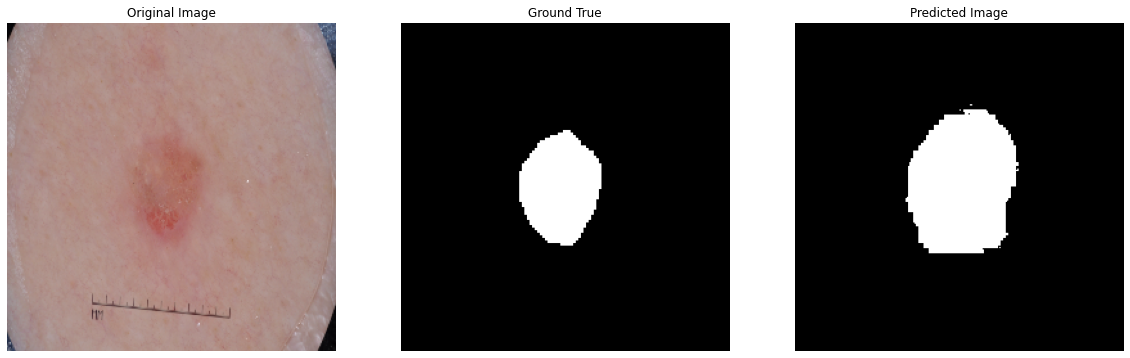

In [31]:
for i in range(3):
    plotResult([x_test[i],y_test[i],pred[i]])

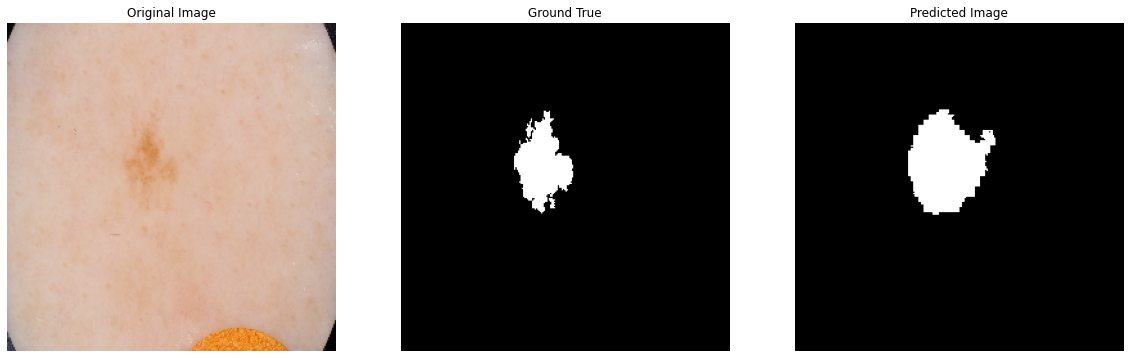

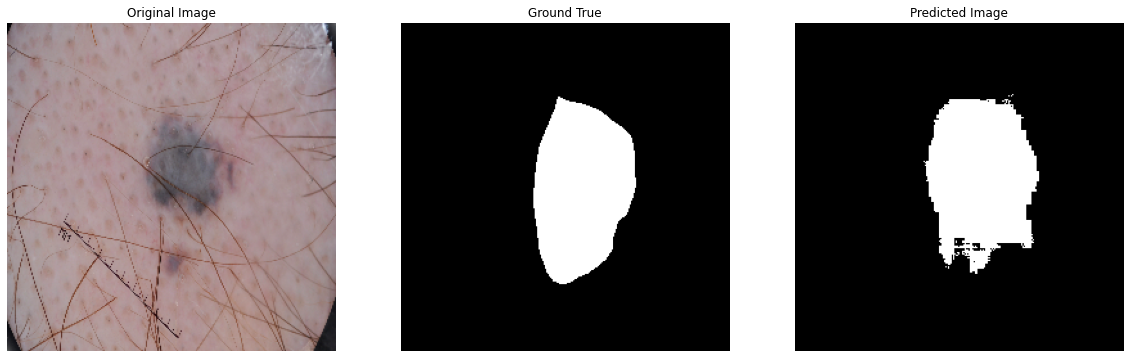

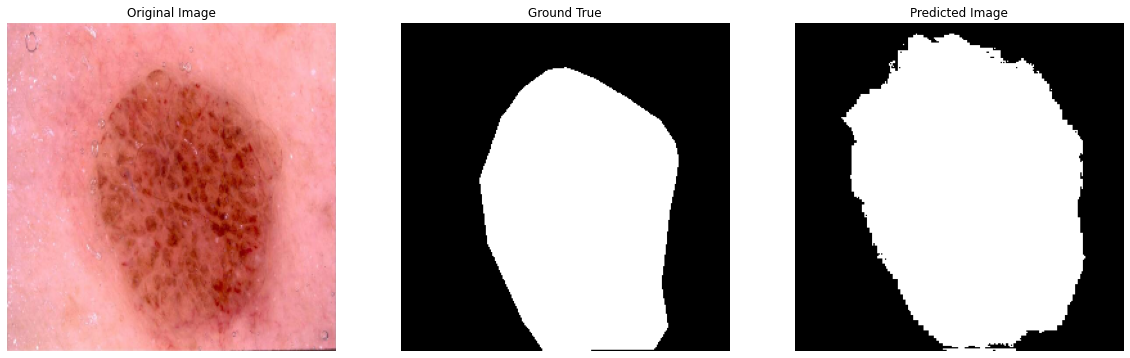

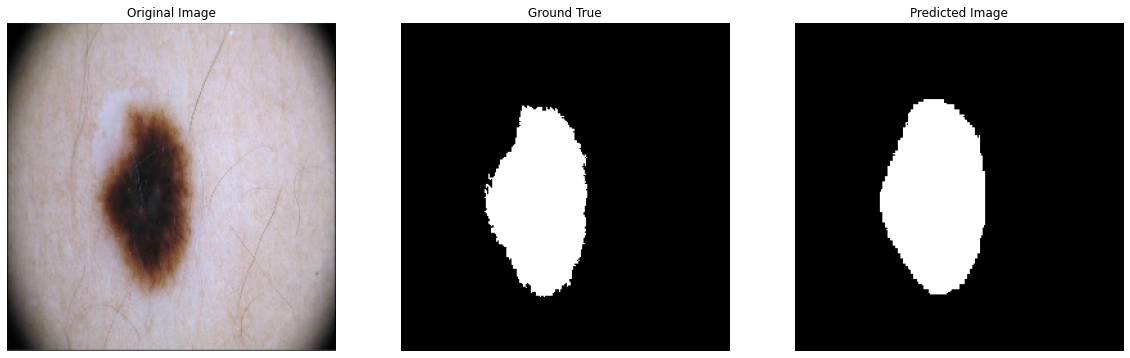

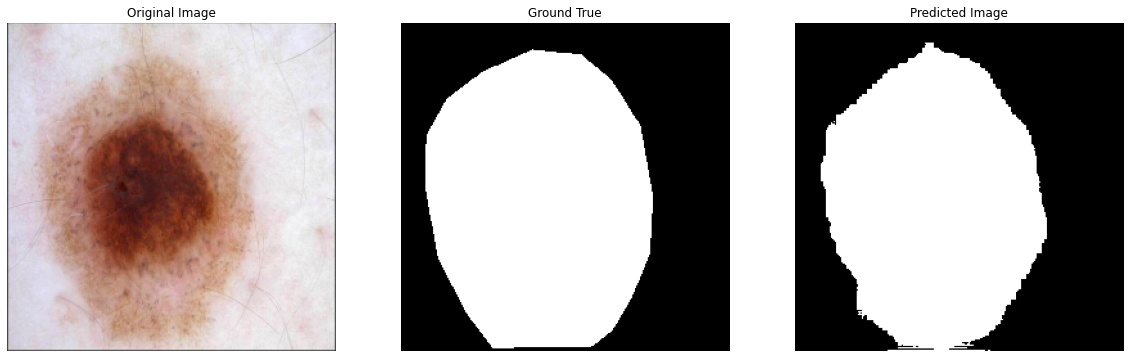

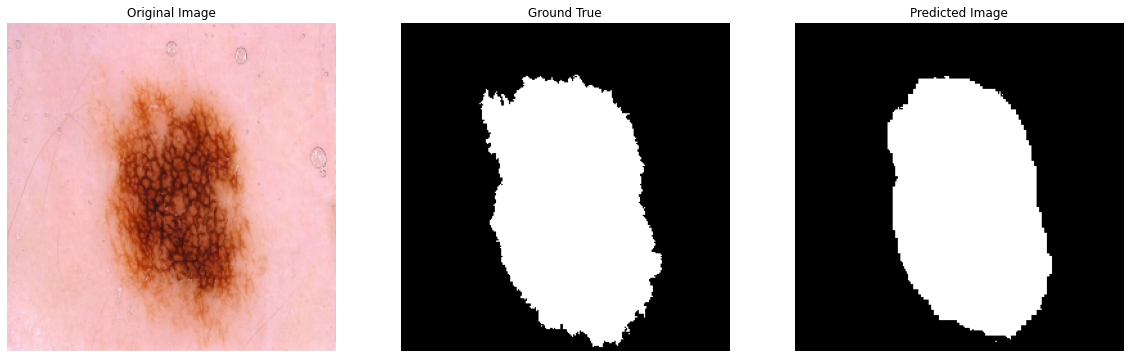

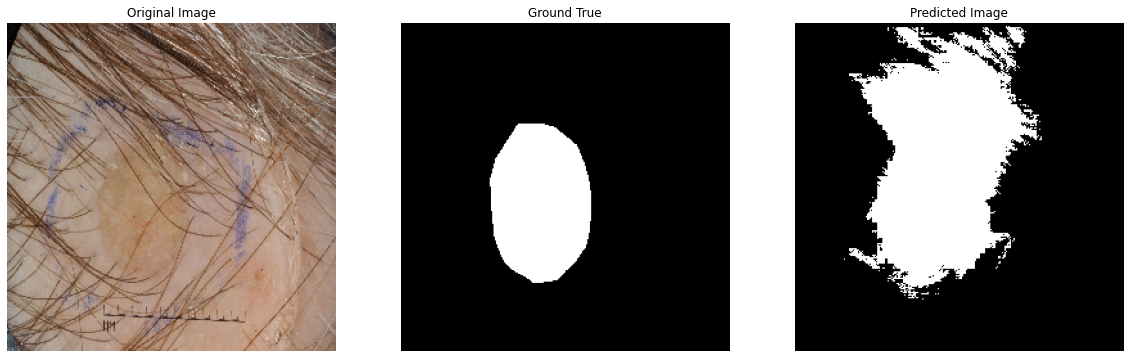

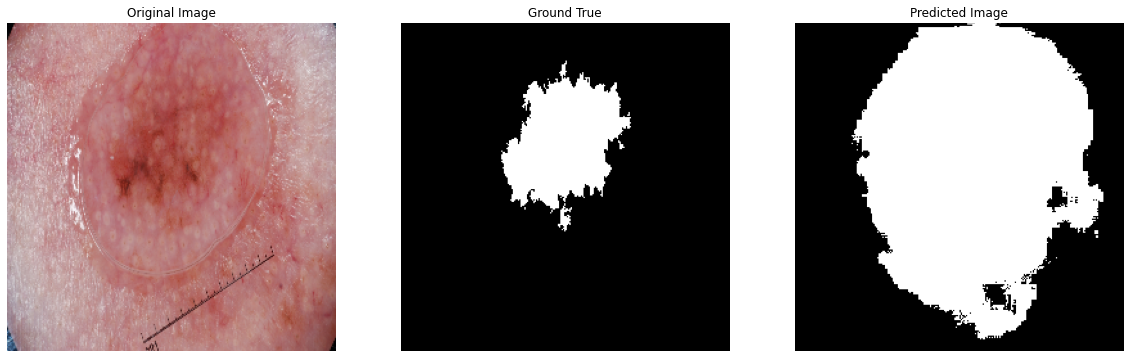

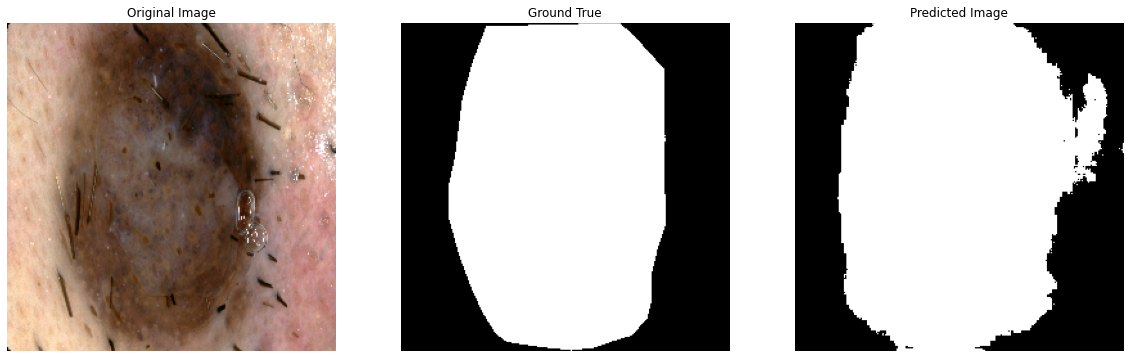

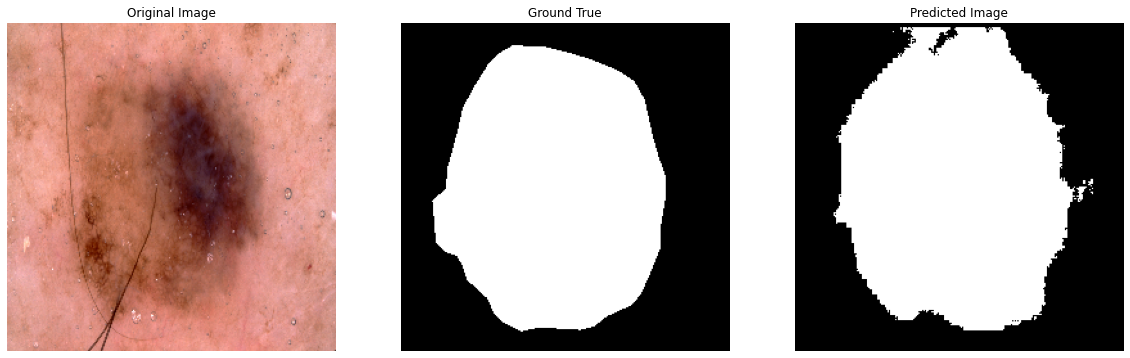

In [32]:
for i in range(10):
    j=i+10
    plotResult([x_test[j],y_test[j],pred[j]])